# 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [1]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Komoran
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-12-03 00:36:41.734150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 00:36:42.285969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1) 데이터 로드하기
* 링크로부터 훈련 데이터에 해당하는 ratings_train.txt와 테스트 데이터에 해당하는 ratings_test.txt를 다운로드 한다.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fb7a3f1cfd0>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


해당 데이터는 id, document, label 총 3개의 열로 구성되어져 있습니다. id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시합니다. 결국 이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 학습하는 모델이 되어야 합니다.

또한 단지 상위 5개의 샘플만 출력해보았지만 한국어 데이터와 영어 데이터의 차이를 확인할 수 있습니다. 예를 들어, 인덱스 2번 샘플은 띄어쓰기를 하지 않아도 글을 쉽게 이해할 수 있는 한국어의 특성으로 인해 띄어쓰기가 되어있지 않습니다.

## 2) 데이터 정제하기

* 데이터 중복 유무를 확인한다

In [5]:
train_data['document'].nunique(),train_data['label'].nunique()

(146182, 2)

* 총 15만개의 샘플이 존재하는데 중복을 제거하면 14만6천개이므로 4천개의 중복이 발생한다 이를 제거한다.

In [6]:
train_data.drop_duplicates(subset = ['document'],inplace = True)

<AxesSubplot: >

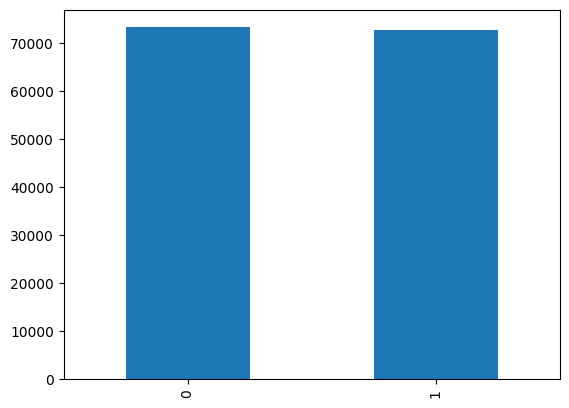

In [8]:
train_data['label'].value_counts().plot(kind='bar')

* 중복 샘플이 제거 된후 레이블 값의 분포를 보면 긍정과 부정의 샘플 사이즈가 비슷한 걸 확인할 수 있다.

In [10]:
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

* 레이블이 0인 데이터가 근소하게 많다. 리뷰중 Null 값을 가진 샘플이 있는지 확인해보겠다.


In [12]:
train_data.isnull().values.any()

True

* True가 나왔으므로 Null값을 가진 샘플이 존재한다는 의미이다

In [13]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

* document열이 Null값을 가진 샘플이 1개 존재한다고 돼있다.
    * 그렇다면 어느 위치에 있는지 출력해보자

In [15]:
train_data.loc[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
train_data = train_data.dropna()
train_data.isna().sum()

id          0
document    0
label       0
dtype: int64

데이터의 전처리를 수행해보겠습니다. 위의 train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인했습니다. train_data로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용해보겠습니다.

위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 되겠습니다. 우선 자음과 모음에 대한 범위를 지정해보겠습니다. 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다. 해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 아래의 링크를 참고하시기 바랍니다.

링크 : https://www.unicode.org/charts/PDF/U3130.pdf ㄱ ~ ㅎ: 3131 ~ 314E ㅏ ~ ㅣ: 314F ~ 3163

완성형 한글의 범위는 가 ~ 힣과 같이 사용합니다. 해당 범위 내에 포함된 음절들은 아래의 링크에서 확인할 수 있습니다.

링크 : https://www.unicode.org/charts/PDF/UAC00.pdf 위 범위 지정을 모두 반영하여 train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해봅시다.

In [17]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하곤 전부 제거
train_data[:5]

/tmp/ipykernel_1454806/3536793883.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


상위 5개의 샘플을 다시 출력해보았는데, 정규 표현식을 수행하자 기존의 공백. 즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었습니다.
사실 네이버 영화 리뷰는 한글이 아니더라도 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있습니다.
다시 말해 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것입니다.
train_data에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인해보겠습니다.

In [18]:
train_data['document'] = train_data['document'].str.replace('^ +',"")
# .replace() 데이터프레임에서 해당하는 값의 원소를 지정한 원소로 바꿔주는
# 클래스 메소드
train_data['document'].replace('',np.nan,inplace = True)
train_data.isna().sum()

/tmp/ipykernel_1454806/3273395563.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +',"")


id            0
document    789
label         0
dtype: int64

* Null Sample을 제거한다.

In [20]:
train_data = train_data.dropna()

### Test 데이터셋에 대해서도 위에서 적용한 걸 그대로 적용한다.

In [21]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/tmp/ipykernel_1454806/3570305079.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_1454806/3570305079.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


## 3) 토큰화
토큰화를 진행해봅시다. 토큰화 과정에서 불용어를 제거하겠습니다. 불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다. 실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용할 수 있습니다.

In [23]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [24]:
komoran = Komoran()

* train_data와 test_data에 형태소 분석기를 사용하여 토큰화를 하면서 동시에 불용어를 제거하여 저장

In [25]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = komoran.morphs(sentence)
    stopwords_removed_sentence = [word for word in tokenized_sentence if word not in stopwords]
    X_train.append(stopwords_removed_sentence)
    

100%|██████████| 145393/145393 [00:56<00:00, 2571.14it/s]


In [26]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = komoran.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:20<00:00, 2342.90it/s]


In [27]:
X_train[:5]

[['아', '더빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무재밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '다', '평점', '조정'],
 ['사이몬페그의',
  '익살',
  '스럽',
  'ㄴ',
  '연기',
  '돋보이',
  '었',
  '던',
  '영화',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '하',
  '았',
  '던',
  '커스틴 던스트',
  '너무나',
  '이뻐보였다']]

## 4) 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 한다. 우선, 훈련 데이터에 대해서 단어집합을 만들어보자

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

* keras에 Tokenizer로 데이터를 fit하면 단어집합이 생성되는 동시에 단어에 고유한 정수가 부여된다.

In [29]:
tokenizer.word_index

{'하': 1,
 'ㄴ': 2,
 '영화': 3,
 '다': 4,
 '보': 5,
 '고': 6,
 '을': 7,
 '았': 8,
 '게': 9,
 'ㄹ': 10,
 '었': 11,
 '어': 12,
 '지': 13,
 '아': 14,
 '있': 15,
 'ㅁ': 16,
 '없': 17,
 '나': 18,
 '되': 19,
 '만': 20,
 '좋': 21,
 '는데': 22,
 '주': 23,
 '너무': 24,
 '것': 25,
 '기': 26,
 '적': 27,
 '정말': 28,
 '점': 29,
 '음': 30,
 '내': 31,
 '같': 32,
 '네': 33,
 '안': 34,
 'ㄴ다': 35,
 '에서': 36,
 '로': 37,
 '진짜': 38,
 '재밌': 39,
 '지만': 40,
 '않': 41,
 '아니': 42,
 '어요': 43,
 '만들': 44,
 '아서': 45,
 '네요': 46,
 '말': 47,
 '수': 48,
 '연기': 49,
 '거': 50,
 '면': 51,
 '나오': 52,
 '평점': 53,
 'ㅂ니다': 54,
 '최고': 55,
 '던': 56,
 '왜': 57,
 '그': 58,
 '뭐': 59,
 '겠': 60,
 '스토리': 61,
 '생각': 62,
 '이런': 63,
 '때': 64,
 '습니다': 65,
 '시': 66,
 '드라마': 67,
 '사람': 68,
 '배우': 69,
 '보다': 70,
 '더': 71,
 '감동': 72,
 '싶': 73,
 '까지': 74,
 '알': 75,
 '라': 76,
 '어서': 77,
 '아깝': 78,
 '내용': 79,
 '요': 80,
 '오': 81,
 '감독': 82,
 '그냥': 83,
 '듯': 84,
 '재': 85,
 '재미있': 86,
 '시간': 87,
 '중': 88,
 '재미': 89,
 '지루': 90,
 '아도': 91,
 '이렇': 92,
 '쓰레기': 93,
 '재미없': 94,
 '이것': 95,
 'ㄴ데': 96

* 등장 빈도수가 낮은 단어에 대해서는 자연어처리에서 배제하고자 한다.

In [30]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 54414
등장 빈도가 2번 이하인 희귀 단어의 수: 36551
단어 집합에서 희귀 단어의 비율: 67.17205131032455
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9308048906916706


등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.93%밖에 되지 않습니다. 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [31]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 17864


* 단어 집합의 크기는 17864개이다. 이를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환한다.

In [32]:
# Tokenizer의 주요 매개변수는 num_words와 oov_token으로 
# num_words: 사용할 단어 수를 지정함으로써 빈도가 높은 num_words개만을 사용하여 단어집합을 구성한다.
# oov_token: 사전에 없는 단어에 대한 토큰을 지정한다.
# 기본값은 None
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [34]:
y_train = np.array(train_data['label'])

In [35]:
y_train

array([0, 1, 0, ..., 0, 1, 0])

In [36]:
y_test = np.array(test_data['label'])

In [37]:
y_test

array([1, 0, 0, ..., 0, 0, 0])

각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다. 단어의 개수는 17,864개로 제한되었으므로 0번 단어 ~ 17,863번 단어까지만 사용 중입니다. 0번 단어는 패딩을 위한 토큰임을 상기합시다. train_data에서 y_train과 y_test를 별도로 저장해줍니다 .

In [41]:
X_train[:3]
# 빈샘플이 보이게 된다.

[[14, 488, 38, 206, 18, 46, 717],
 [986, 512, 212, 661, 3, 183, 1467, 49, 809, 722, 13, 41, 383],
 []]

## 5) 빈 샘플(empty samples) 제거
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플(`[[]]`)이 되었다는 것을 의미합니다.
빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업을 하겠습니다.
각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오겠습니다.

In [43]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [44]:
drop_train

[2,
 10,
 28,
 208,
 252,
 319,
 619,
 653,
 727,
 748,
 758,
 797,
 844,
 1029,
 1040,
 1061,
 1068,
 1145,
 1194,
 1204,
 1213,
 1280,
 1293,
 1347,
 1535,
 1572,
 1685,
 1761,
 1804,
 1831,
 1901,
 1905,
 2147,
 2155,
 2167,
 2201,
 2215,
 2238,
 2321,
 2345,
 2383,
 2432,
 2482,
 2572,
 2575,
 2598,
 2685,
 2830,
 2901,
 2978,
 3091,
 3094,
 3111,
 3154,
 3181,
 3233,
 3240,
 3245,
 3341,
 3361,
 3386,
 3396,
 3414,
 3451,
 3563,
 3564,
 3620,
 3645,
 3650,
 3692,
 3969,
 4073,
 4192,
 4288,
 4323,
 4430,
 4599,
 4623,
 4687,
 4690,
 4754,
 4757,
 4881,
 5186,
 5275,
 5301,
 5409,
 5465,
 5629,
 5651,
 5722,
 5877,
 5897,
 5902,
 5962,
 6096,
 6105,
 6137,
 6216,
 6231,
 6327,
 6418,
 6433,
 6462,
 6506,
 6586,
 6589,
 6689,
 6706,
 6717,
 6801,
 6977,
 7141,
 7227,
 7370,
 7482,
 7540,
 7544,
 7680,
 7790,
 7906,
 7926,
 8033,
 8081,
 8130,
 8205,
 8276,
 8281,
 8318,
 8343,
 8376,
 8415,
 8448,
 8566,
 8577,
 8590,
 8666,
 8675,
 8716,
 8771,
 8797,
 8845,
 8948,
 8957,
 8973,
 8

In [47]:
drop_test

[9,
 59,
 74,
 110,
 172,
 485,
 589,
 689,
 863,
 893,
 895,
 1020,
 1048,
 1276,
 1281,
 1690,
 1729,
 1740,
 1747,
 1812,
 1817,
 1831,
 1982,
 2022,
 2156,
 2248,
 2280,
 2288,
 2315,
 2373,
 2374,
 2463,
 2476,
 2494,
 2546,
 2584,
 2617,
 2654,
 2683,
 2715,
 2780,
 2929,
 3034,
 3087,
 3101,
 3218,
 3237,
 3496,
 3510,
 3726,
 3814,
 3928,
 4000,
 4192,
 4202,
 4257,
 4334,
 4384,
 4539,
 4581,
 4590,
 4609,
 4753,
 4756,
 4771,
 4924,
 4932,
 4936,
 4951,
 5022,
 5082,
 5173,
 5226,
 5415,
 5459,
 5585,
 5672,
 5683,
 5782,
 5923,
 5924,
 6220,
 6231,
 6238,
 6321,
 6419,
 6465,
 6538,
 6589,
 6640,
 6696,
 6702,
 6732,
 6802,
 6845,
 6856,
 6918,
 6919,
 7035,
 7056,
 7062,
 7143,
 7144,
 7202,
 7224,
 7292,
 7421,
 7425,
 7506,
 7642,
 7698,
 7700,
 7703,
 7760,
 7763,
 7778,
 7821,
 7857,
 7984,
 7992,
 8174,
 8191,
 8224,
 8227,
 8275,
 8304,
 8360,
 8393,
 8399,
 8411,
 8422,
 8428,
 8479,
 8553,
 8815,
 8988,
 9013,
 9046,
 9061,
 9108,
 9146,
 9214,
 9228,
 9247,
 9259,


In [48]:
# Return a new array with sub-arrays along an axis deleted. For a one
# dimensional array, this returns those entries not returned by `arr[obj]`.
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [49]:
X_test = np.delete(X_test, drop_test, axis=0)

In [50]:
y_test = np.delete(y_test, drop_test, axis=0)

## 6) 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

In [61]:
X_train[:4]

array([list([14, 488, 38, 206, 18, 46, 717]),
       list([986, 512, 212, 661, 3, 183, 1467, 49, 809, 722, 13, 41, 383]),
       list([5821, 141, 3365, 269, 89, 17, 4, 53, 3545]),
       list([7546, 119, 2, 49, 840, 11, 56, 3, 2736, 36, 1133, 12, 107, 26, 20, 1, 8, 56, 397])],
      dtype=object)

리뷰의 최대 길이 : 104
리뷰의 평균 길이 : 14.900742873515826


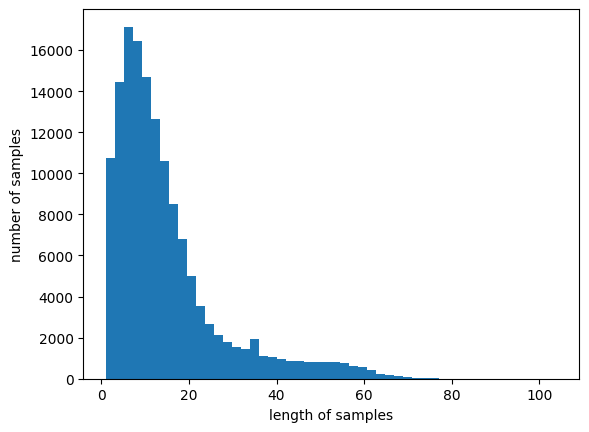

In [60]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


가장 긴 리뷰의 길이는 104이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 15 내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [63]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))


In [64]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 89.40758807209296


전체 훈련 데이터 중 약 89%의 리뷰가 30이하의 길이를 가지는 것을 확인했습니다. 모든 샘플의 길이를 30으로 맞추겠습니다.

In [66]:
X_train

array([list([14, 488, 38, 206, 18, 46, 717]),
       list([986, 512, 212, 661, 3, 183, 1467, 49, 809, 722, 13, 41, 383]),
       list([5821, 141, 3365, 269, 89, 17, 4, 53, 3545]), ...,
       list([9, 59, 80, 1394, 6, 9695, 9633, 1069, 4]),
       list([9796, 2152, 2808, 1121, 1, 8, 56, 464, 7283]),
       list([163, 3, 1724, 37, 48, 626, 1, 79, 1360, 2, 3])], dtype=object)

In [69]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train,maxlen = max_len)
X_test = pad_sequences(X_test,maxlen = max_len)

# 2. LSTM으로 네이버 영화 리뷰 감성 분류하기
하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128입니다.
모델은 다 대 일 구조의 LSTM을 사용합니다..
해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다..
이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고,.
손실 함수로 크로스 엔트로피 함수를 사용합니다. 하이퍼파라미터인 배치 크기는 64이며, 10 에포크를 수행합니다.

validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고,.
검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다..
검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam

In [71]:
model = Sequential([
    Embedding(vocab_size, 100),  
    # 원핫인코딩 벡터 사이즈 = vocab_size
    # Dense 벡터 사이즈 = 100
    LSTM(128), 
    # hidden state크기 = 128
    Dense(1, activation='sigmoid')])    

model.summary() # 모델의 요약정보 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1786400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1903777 (7.26 MB)
Trainable params: 1903777 (7.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-03 01:26:24.075406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-03 01:26:24.080002: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


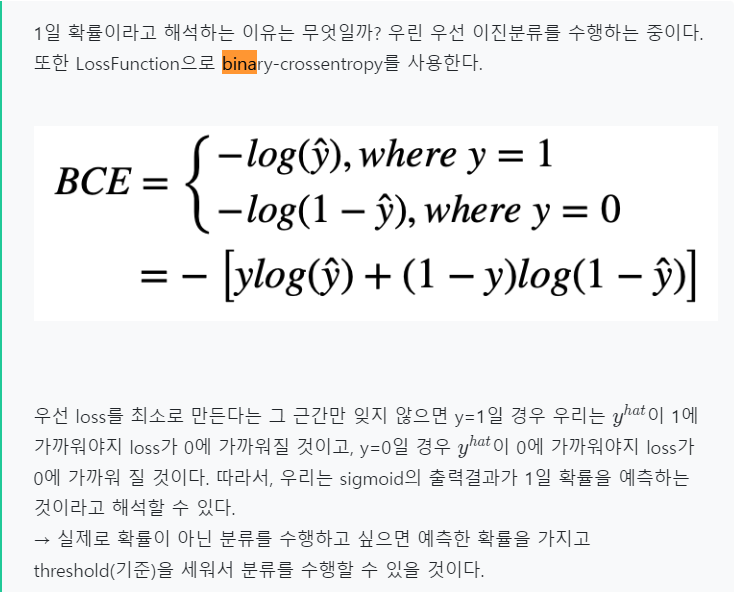

In [72]:
adam = Adam(learning_rate = 1e-4)
model.compile(optimizer = adam, loss = 'binary_crossentropy',metrics = ['acc'])
history = model.fit(X_train,y_train,
                   epochs = 3, batch_size = 64,
                   validation_split = 0.2)

Epoch 1/3
1789/1789 [==============================] - 37s 20ms/step - loss: 0.4831 - acc: 0.7733 - val_loss: 0.3978 - val_acc: 0.8269
Epoch 2/3
1789/1789 [==============================] - 35s 20ms/step - loss: 0.3641 - acc: 0.8411 - val_loss: 0.3733 - val_acc: 0.8352
Epoch 3/3
1789/1789 [==============================] - 35s 20ms/step - loss: 0.3346 - acc: 0.8563 - val_loss: 0.3735 - val_acc: 0.8347


In [73]:
score = model.evaluate(X_test,y_test)
print(f'Test accuracy:{score[1]:.3f}')

1504/1504 [==============================] - 5s 4ms/step - loss: 0.3748 - acc: 0.8350
Test accuracy:0.835


테스트 데이터에서 83.7%의 정확도를 얻습니다. 위 코드는 뒤에서 이어질 네이버 쇼핑 리뷰 분류 실습과 한국어 스팀 리뷰 감성 분류 실습에서도 거의 동일하게 사용될 코드입니다.

# 3. 리뷰 예측해보기
임의의 리뷰에 대해서 예측하는 함수를 만들어보겠습니다. 기본적으로 현재 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용합니다. 그리고 model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 합니다.

In [88]:
# 어떤 입력이 들어왔을때 예측을 수행하는 함수
def sentiment_predict(new_sentence):
    # new_sentence에서 left pattern에 해당하는 것을 가운데에 문자열로 바꿔줌
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = komoran.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if word not in stopwords] # 불용어 제거
    # 정수 인코딩
    # 기본적으로 텍스트의 리스트를 받는다.
    # tokenizer.texts_to_sequences(['말이 경마장에 뛰고 있다'])
    # tokenizer.texts_to_sequences([['말이','경마장에','뛰고','있다']])
    # word의 리스트는 하나의 텍스트로 본다.
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [89]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 11ms/step
50.90% 확률로 부정 리뷰입니다.



In [76]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 11ms/step
78.83% 확률로 부정 리뷰입니다.



# [[실습 12-1]] vanilla RNN vs LSTM
위의 코드 중 LSTM을 사용한 부분의 코드를 vanilla RNN을 사용하도록 수정하고, 정확도를 비교하시오.
```
model = Sequential([Embedding(vocab_size, 100),
    LSTM(128),
    Dense(1, activation='sigmoid')])

model.summary() # 모델의 요약정보 출력
```

In [77]:
from tensorflow.keras.layers import SimpleRNN

In [78]:
model = Sequential([Embedding(vocab_size, 100),      ### ... 이 부분을 완성하시오
    SimpleRNN(128),       ### ... 이 부분을 완성하시오
    Dense(1, activation='sigmoid')])     ### ... 이 부분을 완성하시오

model.summary() # 모델의 요약정보 출력

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1786400   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1815841 (6.93 MB)
Trainable params: 1815841 (6.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
# 시간 상의 이유로 3 epoch으로 실험 (5분 내외 소요)
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=3, batch_size=64,
                    validation_split=0.2)

Epoch 1/3
1789/1789 [==============================] - 23s 12ms/step - loss: 0.4957 - acc: 0.7463 - val_loss: 0.4073 - val_acc: 0.8154
Epoch 2/3
1789/1789 [==============================] - 20s 11ms/step - loss: 0.3601 - acc: 0.8425 - val_loss: 0.3812 - val_acc: 0.8332
Epoch 3/3
1789/1789 [==============================] - 20s 11ms/step - loss: 0.3225 - acc: 0.8640 - val_loss: 0.3856 - val_acc: 0.8306


In [80]:
score = model.evaluate(X_test, y_test)
print(f'Test accuracy:{score[1]:.3f}')

1504/1504 [==============================] - 2s 1ms/step - loss: 0.3866 - acc: 0.8285
Test accuracy:0.828


# RNN 이해하기

In [81]:
text_list = ['경마장에 있는 말이 뛰고 있다',
            '그의 말이 법이다',
            '가는 말이 고와야 오는 말이 곱다']

In [82]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
# 단어 집합 생성
tokenizer.fit_on_texts(text_list)

In [83]:
tokenizer.word_index

{'말이': 1,
 '경마장에': 2,
 '있는': 3,
 '뛰고': 4,
 '있다': 5,
 '그의': 6,
 '법이다': 7,
 '가는': 8,
 '고와야': 9,
 '오는': 10,
 '곱다': 11}

In [84]:
# padding에 사용되는 index:0
vocab_size = len(tokenizer.word_index)+1
print("단어집합의 크기:",vocab_size)

단어집합의 크기: 12


In [91]:
sequences = []
for line in text_list:
    print("현재문장",line)
    encoded = tokenizer.texts_to_sequences([line])[0]
    print("인코딩된 결과",encoded)
    for i in range(1,len(encoded)):
        sequence = encoded[:i+1] # 학습데이터와 타겟데이터 둘다 포함한거임
        print(sequence)
        print("학습 샘플",sequence)
        sequences.append(sequence)

현재문장 경마장에 있는 말이 뛰고 있다
인코딩된 결과 [2, 3, 1, 4, 5]
[2, 3]
학습 샘플 [2, 3]
[2, 3, 1]
학습 샘플 [2, 3, 1]
[2, 3, 1, 4]
학습 샘플 [2, 3, 1, 4]
[2, 3, 1, 4, 5]
학습 샘플 [2, 3, 1, 4, 5]
현재문장 그의 말이 법이다
인코딩된 결과 [6, 1, 7]
[6, 1]
학습 샘플 [6, 1]
[6, 1, 7]
학습 샘플 [6, 1, 7]
현재문장 가는 말이 고와야 오는 말이 곱다
인코딩된 결과 [8, 1, 9, 10, 1, 11]
[8, 1]
학습 샘플 [8, 1]
[8, 1, 9]
학습 샘플 [8, 1, 9]
[8, 1, 9, 10]
학습 샘플 [8, 1, 9, 10]
[8, 1, 9, 10, 1]
학습 샘플 [8, 1, 9, 10, 1]
[8, 1, 9, 10, 1, 11]
학습 샘플 [8, 1, 9, 10, 1, 11]


In [92]:
l_len_list = []
for l in sequences:
    l_len_list.append(len(l))
print(l_len_list)
max_len = max(l_len_list)
print("샘플의 최대 길이:{}".format(max_len))

[2, 3, 4, 5, 2, 3, 2, 3, 4, 5, 6]
샘플의 최대 길이:6


In [93]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences,maxlen = max_len, padding = 'pre')

In [95]:
sequences

array([[ 0,  0,  0,  0,  2,  3],
       [ 0,  0,  0,  2,  3,  1],
       [ 0,  0,  2,  3,  1,  4],
       [ 0,  2,  3,  1,  4,  5],
       [ 0,  0,  0,  0,  6,  1],
       [ 0,  0,  0,  6,  1,  7],
       [ 0,  0,  0,  0,  8,  1],
       [ 0,  0,  0,  8,  1,  9],
       [ 0,  0,  8,  1,  9, 10],
       [ 0,  8,  1,  9, 10,  1],
       [ 8,  1,  9, 10,  1, 11]], dtype=int32)

In [96]:
X = sequences[:,:-1]
y = sequences[:,-1]

In [98]:
X

array([[ 0,  0,  0,  0,  2],
       [ 0,  0,  0,  2,  3],
       [ 0,  0,  2,  3,  1],
       [ 0,  2,  3,  1,  4],
       [ 0,  0,  0,  0,  6],
       [ 0,  0,  0,  6,  1],
       [ 0,  0,  0,  0,  8],
       [ 0,  0,  0,  8,  1],
       [ 0,  0,  8,  1,  9],
       [ 0,  8,  1,  9, 10],
       [ 8,  1,  9, 10,  1]], dtype=int32)

In [100]:
# y를 단어집합 size의 one hot vector로 만들어줘야 한다.
one_hot_vectors = []
for num in y:
    vector = [0]*(vocab_size)
    vector[num] = 1
    one_hot_vectors.append(vector)
print(one_hot_vectors)


[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]


In [101]:
# keras는 numpy array만 처리할 수 있기 때문에, np.array로 감싸준다.
y = np.array(one_hot_vectors)
y

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,SimpleRNN
embedding_dim = 10
hidden_units = 32
model = Sequential(
    [
        Embedding(vocab_size,embedding_dim),
        SimpleRNN(hidden_units),
        Dense(vocab_size,activation = "softmax")
     ]
)

In [103]:
model.compile(loss = "categorical_crossentropy",
              optimizer = 'adam',
              metrics = ['accuracy'])
model.fit(X,y,epochs = 200, verbose = 1)

Epoch 1/200
1/1 [==============================] - 1s 592ms/step - loss: 2.4957 - accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 2.4811 - accuracy: 0.1818
Epoch 3/200
1/1 [==============================] - 0s 2ms/step - loss: 2.4668 - accuracy: 0.1818
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 2.4524 - accuracy: 0.1818
Epoch 5/200
1/1 [==============================] - 0s 2ms/step - loss: 2.4379 - accuracy: 0.1818
Epoch 6/200
1/1 [==============================] - 0s 2ms/step - loss: 2.4232 - accuracy: 0.2727
Epoch 7/200
1/1 [==============================] - 0s 2ms/step - loss: 2.4081 - accuracy: 0.3636
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 2.3924 - accuracy: 0.3636
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 2.3761 - accuracy: 0.3636
Epoch 10/200
1/1 [==============================] - 0s 2ms/step - loss: 2.3590 - accuracy: 0.3636
Epoch 11/200
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 0.2478 - accuracy: 0.9091
Epoch 168/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2437 - accuracy: 0.9091
Epoch 169/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2396 - accuracy: 0.9091
Epoch 170/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2355 - accuracy: 0.9091
Epoch 171/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2315 - accuracy: 1.0000
Epoch 172/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2276 - accuracy: 1.0000
Epoch 173/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2237 - accuracy: 1.0000
Epoch 174/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2199 - accuracy: 1.0000
Epoch 175/200
1/1 [==============================] - 0s 3ms/step - loss: 0.2162 - accuracy: 1.0000
Epoch 176/200
1/1 [==============================] - 0s 2ms/step - loss: 0.2125 - accuracy: 1.0000
Epoch 177/200
1/1 [=====

##  sentence 다음에 나올 단어 예측하기

In [104]:
test_sentence = "경마장에 있는" # 말이 를 맞추고 싶다.

In [105]:
encoded = tokenizer.texts_to_sequences([test_sentence])[0]

In [106]:
encoded

[2, 3]

In [107]:
encoded = pad_sequences([encoded],maxlen = 5, padding = 'pre')

In [108]:
encoded

array([[0, 0, 0, 2, 3]], dtype=int32)

In [109]:
y_hat = model.predict(encoded)

1/1 [==============================] - 0s 72ms/step


In [110]:
y_hat

array([[8.8787079e-04, 9.0266681e-01, 6.2926963e-04, 6.6357180e-02,
        2.3058471e-03, 9.7861257e-04, 4.7123959e-04, 1.8994730e-02,
        7.8388368e-04, 3.2998517e-03, 1.3009512e-03, 1.3238589e-03]],
      dtype=float32)

In [131]:
np.argmax(y_hat,axis = 1)

array([1])

In [114]:
tokenizer.word_index

{'말이': 1,
 '경마장에': 2,
 '있는': 3,
 '뛰고': 4,
 '있다': 5,
 '그의': 6,
 '법이다': 7,
 '가는': 8,
 '고와야': 9,
 '오는': 10,
 '곱다': 11}

In [115]:
tokenizer.index_word

{1: '말이',
 2: '경마장에',
 3: '있는',
 4: '뛰고',
 5: '있다',
 6: '그의',
 7: '법이다',
 8: '가는',
 9: '고와야',
 10: '오는',
 11: '곱다'}

In [116]:
tokenizer.index_word[1]

'말이'

In [123]:
tokenizer.texts_to_sequences(['말이 경마장에 뛰고 있다'])

[[1, 2, 4, 5]]

In [127]:
tokenizer.texts_to_sequences([['말이','경마장에','뛰고','있다']])

[[1, 2, 4, 5]]

In [129]:
pad_sequences([[1]],maxlen = 5, padding = 'pre')

array([[0, 0, 0, 0, 1]], dtype=int32)

In [132]:
def sentence_generation(model,tokenizer,current_word,n):
    # current_word 다음에 올 n개의 단어를 예측
    init_word = current_word
    sentence = ''
    for _ in range(n):
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded  = pad_sequences([encoded],maxlen = 5, padding = 'pre')
        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장
        result = model.predict(encoded,verbose = 0)
        result = np.argmax(result,axis = 1)
        # result = [a] 형태임
        word = tokenizer.index_word[result[0]]
        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' ' + word
        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word
    sentence = init_word + sentence
    return sentence

        

In [133]:
print(sentence_generation(model,tokenizer,'경마장에',4))
print(sentence_generation(model,tokenizer,'그의',2))
print(sentence_generation(model,tokenizer,'가는',5))
print(sentence_generation(model,tokenizer,'경마장에 있는',3))

경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다
경마장에 있는 말이 뛰고 있다


# [[실습 12-2]] 케라스의 SimpleRNN, LSTM, Bi-LSTM 이해하기

In [134]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional

In [141]:
# RNN은 3D 텐서를 입력으로 받는다
# 배치크기를 1로 둬서 해결한다.
train_X = np.array([[[0.1, 4.2, 1.5, 1.1, 2.8],
           [1.0, 3.1, 2.5, 0.7, 1.1],
           [0.3, 2.1, 1.5, 2.1, 0.1],
           [2.2, 1.4, 0.5, 0.9, 1.1]]],dtype = np.float32)
print(np.shape(train_X))

(1, 4, 5)


In [142]:
train_X

array([[[0.1, 4.2, 1.5, 1.1, 2.8],
        [1. , 3.1, 2.5, 0.7, 1.1],
        [0.3, 2.1, 1.5, 2.1, 0.1],
        [2.2, 1.4, 0.5, 0.9, 1.1]]], dtype=float32)

In [143]:
rnn = SimpleRNN(3)
# rnn = SimpleRNN(3, return_sequences=False, return_state=False)와 동일.
hidden_state = rnn(train_X)

print('hidden state : {}, shape: {}'.format(hidden_state, hidden_state.shape))


hidden state : [[-0.46760938  0.98775357  0.96221405]], shape: (1, 3)


In [144]:
rnn = SimpleRNN(3, return_sequences=True)
hidden_states = rnn(train_X)

print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))


hidden states : [[[-0.6809463   0.9996804  -0.992656  ]
  [-0.9746864   0.9966296  -0.9998115 ]
  [-0.9199003   0.83387876 -0.99979347]
  [-0.06352667  0.34328216 -0.99767464]]], shape: (1, 4, 3)


In [147]:
# Many to Many
rnn = SimpleRNN(3, return_sequences=True, return_state=True)
hidden_states, last_state = rnn(train_X)
# last_state = output
# hidden state의 마지막과 last hidden state가 같다
print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))
print('last hidden state : {}, shape: {}'.format(last_state, last_state.shape))

hidden states : [[[ 0.9441445  -0.5328977  -0.98766947]
  [ 0.97338814 -0.76344305 -0.9824966 ]
  [ 0.85644716 -0.8481058  -0.98865074]
  [-0.01511786 -0.8895691  -0.99603236]]], shape: (1, 4, 3)
last hidden state : [[-0.01511786 -0.8895691  -0.99603236]], shape: (1, 3)


In [148]:
# Many to One
rnn = SimpleRNN(3, return_sequences=False, return_state=True)
hidden_state, last_state = rnn(train_X)

print('hidden state : {}, shape: {}'.format(hidden_state, hidden_state.shape))
print('last hidden state : {}, shape: {}'.format(last_state, last_state.shape))

hidden state : [[-0.49121904  0.83580893 -0.38883215]], shape: (1, 3)
last hidden state : [[-0.49121904  0.83580893 -0.38883215]], shape: (1, 3)


In [149]:
lstm = LSTM(3, return_sequences=False, return_state=True)
hidden_state, last_state, last_cell_state = lstm(train_X)

print('hidden state : {}, shape: {}'.format(hidden_state, hidden_state.shape))
print('last hidden state : {}, shape: {}'.format(last_state, last_state.shape))
print('last cell state : {}, shape: {}'.format(last_cell_state, last_cell_state.shape))

hidden state : [[-0.10757281  0.6739478   0.03896408]], shape: (1, 3)
last hidden state : [[-0.10757281  0.6739478   0.03896408]], shape: (1, 3)
last cell state : [[-0.87027925  1.1890491   0.09096663]], shape: (1, 3)


In [150]:
lstm = LSTM(3, return_sequences=True, return_state=True)
hidden_states, last_hidden_state, last_cell_state = lstm(train_X)

print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))
print('last hidden state : {}, shape: {}'.format(last_hidden_state, last_hidden_state.shape))
print('last cell state : {}, shape: {}'.format(last_cell_state, last_cell_state.shape))

hidden states : [[[ 0.03943485  0.20032242 -0.03948264]
  [ 0.05140872  0.27526665  0.01001079]
  [ 0.08214398  0.34154484  0.02975743]
  [ 0.0942365   0.37897384  0.05101179]]], shape: (1, 4, 3)
last hidden state : [[0.0942365  0.37897384 0.05101179]], shape: (1, 3)
last cell state : [[0.23681113 0.6236774  0.2279934 ]], shape: (1, 3)


In [152]:
k_init = tf.keras.initializers.Constant(value=0.1)
b_init = tf.keras.initializers.Constant(value=0)
r_init = tf.keras.initializers.Constant(value=0.1)

In [153]:
bilstm = Bidirectional(LSTM(3, return_sequences=False, return_state=True,
                            kernel_initializer=k_init,
                            bias_initializer=b_init,
                            recurrent_initializer=r_init))
hidden_states, forward_h, forward_c, backward_h, backward_c = bilstm(train_X)
# hidden_states는 forward hidden state를 의미
print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))
print('forward state : {}, shape: {}'.format(forward_h, forward_h.shape))
print('backward state : {}, shape: {}'.format(backward_h, backward_h.shape))

hidden states : [[0.6303138 0.6303138 0.6303138 0.7038734 0.7038734 0.7038734]], shape: (1, 6)
forward state : [[0.6303138 0.6303138 0.6303138]], shape: (1, 3)
backward state : [[0.7038734 0.7038734 0.7038734]], shape: (1, 3)


In [154]:
bilstm = Bidirectional(LSTM(3, return_sequences=True, return_state=True, \
                            kernel_initializer=k_init, bias_initializer=b_init, recurrent_initializer=r_init))
hidden_states, forward_h, forward_c, backward_h, backward_c = bilstm(train_X)

In [155]:
print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))
print('forward state : {}, shape: {}'.format(forward_h, forward_h.shape))
print('backward state : {}, shape: {}'.format(backward_h, backward_h.shape))

hidden states : [[[0.35906473 0.35906473 0.35906473 0.7038734  0.7038734  0.7038734 ]
  [0.55111325 0.55111325 0.55111325 0.58863586 0.58863586 0.58863586]
  [0.59115744 0.59115744 0.59115744 0.3951699  0.3951699  0.3951699 ]
  [0.6303138  0.6303138  0.6303138  0.21942244 0.21942244 0.21942244]]], shape: (1, 4, 6)
forward state : [[0.6303138 0.6303138 0.6303138]], shape: (1, 3)
backward state : [[0.7038734 0.7038734 0.7038734]], shape: (1, 3)
